In [122]:
import pandas as pd 
import numpy as py
import matplotlib.pyplot as plt

# Import data

In [3]:
testdf = pd.read_csv('test_results.csv')

In [4]:
testdf.head()

,Unnamed: 0,user_id,timestamp,source,device,operative_system,test,price,converted
0,0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0
1,1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0
2,2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0
3,3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0
4,4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0


In [13]:
testdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        316800 non-null  int64  
 1   user_id           316800 non-null  int64  
 2   timestamp         316466 non-null  object 
 3   source            316488 non-null  object 
 4   device            316800 non-null  object 
 5   operative_system  296461 non-null  object 
 6   test              316800 non-null  int64  
 7   price             316800 non-null  float64
 8   converted         316800 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 21.8+ MB


In [5]:
userdf = pd.read_csv('user_table.csv')

In [10]:
userdf.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [11]:
userdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  275616 non-null  int64  
 1   city     275616 non-null  object 
 2   country  275616 non-null  object 
 3   lat      275616 non-null  float64
 4   long     275616 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.5+ MB


In user table, there are 275616 rows data, but in test table, there are 316800 rows, so some of the customers do not have users infos. 

# Data processing and cleaning

In [68]:
# NAN for testdf
nancolumns = ['source','operative_system']
for col in nancolumns:
    testdf[col].fillna('nan', inplace = True) 

In [57]:
testdf['revenue'] = testdf['converted']*testdf['price']

In [78]:
for col in testdf:
    print(col, testdf[col].nunique())

Unnamed: 0 316800
user_id 316800
timestamp 141147
source 13
device 2
operative_system 9
test 2
price 3076
converted 2
revenue 62


Check for 'operative_system' and 'price' as there should be so many unique values

## operative_systme

In [92]:
testdf.rename(columns={'operative_system':'OS'}, inplace = True)
testdf['OS'].unique()

array(['iOS', 'android', 'mac', 'windows', 'nan', 'apple'], dtype=object)

In [93]:
# change i0S to ios, and change wnddows to 'windows', anroid to android
testdf['OS'].replace('i0S', 'iOS', inplace = True)
testdf['OS'].replace('wnddows', 'windows', inplace = True)
testdf['OS'].replace('anroid', 'android', inplace = True)
testdf['OS'].unique()

array(['iOS', 'android', 'mac', 'windows', 'nan', 'apple'], dtype=object)

## Price

In [88]:
testdf.groupby('price')['price'].count()

price
39.0           200747
59.0           112979
324680531.0         1
325355094.0         1
325373202.0         1
                ...  
998765098.0         1
999139431.0         1
999173836.0         1
999762858.0         1
999884279.0         1
Name: price, Length: 3076, dtype: int64

In [91]:
# remove the wrong price
testdf = testdf[testdf['price']<60]
testdf.shape

(313726, 10)

# Check if test and control group is randomly splitted?

In [95]:
from sklearn.preprocessing import LabelEncoder
X = testdf.copy()

# to use sklearn to check feature importance, we must convert string values to numbers
src_label_encoder = LabelEncoder()
dev_label_encoder = LabelEncoder()
os_label_encoder = LabelEncoder()

X["source"] = src_label_encoder.fit_transform(testdf.source)
X["device"] = dev_label_encoder.fit_transform(testdf.device)
X["OS"] = os_label_encoder.fit_transform(testdf.OS)

Run Chi-square test
- non hypothesis: test vs control are random

In [96]:
from sklearn.feature_selection import chi2
colnames = ['source','device','OS']
ch2values,pvalues = chi2(X.loc[:,colnames],X["test"])
pd.DataFrame({'chi2_value':ch2values,'pvalue':pvalues},index = colnames).sort_values(by='pvalue')

,chi2_value,pvalue
OS,76.659430,2.031338e-18
device,44.597887,2.419527e-11
source,0.475361,4.905312e-01


From the results, OS and device are dependent of the group split, so need to check

In [101]:
def calc_ratios(s):
    d = s.value_counts(normalize=True)
    d['total'] = s.shape[0]
    return d
test_ctrl_by_os = testdf.groupby('OS')['test'].apply(calc_ratios).unstack()
test_ctrl_by_os 

,0,1,total
OS,,,
android,0.643383,0.356617,74245.0
apple,0.620690,0.379310,29.0
iOS,0.648160,0.351840,94523.0
mac,0.652780,0.347220,24820.0
nan,0.625031,0.374969,20119.0
windows,0.629793,0.370207,99990.0


we can see that OS distribution in test/control groups are different.

the experiment claim that '66% of the users have seen the old price (39), while a random sample of 33% users a higher price (59).', but users from nan and windows don't exactly obey such rule, where normally 37% users see a higher price. 

# Q1. which price (39, 59) should the company sell?

## Conversion rate

In [106]:
# new price $ 59
new_Conv = testdf[testdf['test'] == 1]['converted'].mean()
print(f'conversion rate with new price is {new_Conv}')

# old price $ 39
old_Conv = testdf[testdf['test'] == 0]['converted'].mean()
print(f'conversion rate with old price is {old_Conv}')

conversion rate with new price is 0.015541426091884808
conversion rate with old price is 0.019890240137050427


From the conversion rate, the new price will lower the conversion rate 

## Average Revenue

In [107]:
# new price $ 59
new_averReve = testdf[testdf['test'] == 1]['revenue'].mean()
print(f'Average revenue with new price is {new_averReve}')

# old price $ 39
old_averReve = testdf[testdf['test'] == 0]['converted'].sum()*39 /oldNum
print(f'Average revenue with old price is {old_averReve}')

Average revenue with new price is 0.9167670291523502
Average revenue with old price is 0.7757193653449667


Clearly, the average revenue with the new price is higher than the old price. If use the average revenue as metric, it seems that the new price did better job. But before give the conclusion, need to check if there is statistically difference between the two mean values.

## T-test for the two means 
- non hypothesis: there is no difference between the two means
- Alternative hypothesis: there is difference between the two means

In [108]:
# collect data
new_Reve = testdf[testdf['test'] == 1]['converted']*59
old_Reve = testdf[testdf['test'] == 0]['converted']*39

from scipy.stats import ttest_ind, ttest_ind_from_stats
t, p = ttest_ind(new_Reve, old_Reve, equal_var=False)
print("ttest_ind: t = %g  p = %g" % (t, p))

ttest_ind: t = 5.67491  p = 1.38971e-08


P is 1.31e-8, much smaller than 0.05 (siginificant level), so can reject the non-hypothesis, i.e, there is no difference betwween the two means.

After the t-test, can conclude that the new price can generate higher average revenue, so should use the new price. 

However, due to OS distribution aren't random between test/control groups, so price is not the only factor influence the revenue. Therefore, to draw a conclusion, I would suggest:

1. find the reason why nan and windows users has a lower ratio in test group than the other OS.
2. Run experiment again, and make sure price is the only difference between test and control group. 


# Q2. How to increase conversion rate

## Merge the data of test_result and user infos

In [109]:
df = pd.merge(testdf, userdf, how= 'left', on = 'user_id')

##  EDA and data manipulation

In [110]:
df.head()

,Unnamed: 0,user_id,timestamp,source,device,OS,test,price,converted,revenue,city,country,lat,long
0,0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0,0.0,Buffalo,USA,42.89,-78.86
1,1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0,0.0,Lakeville,USA,44.68,-93.24
2,2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0,0.0,Parma,USA,41.38,-81.73
3,3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0,0.0,Fayetteville,USA,35.07,-78.90
4,4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0,0.0,Fishers,USA,39.95,-86.02


In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313726 entries, 0 to 313725
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  313726 non-null  int64  
 1   user_id     313726 non-null  int64  
 2   timestamp   313396 non-null  object 
 3   source      313726 non-null  object 
 4   device      313726 non-null  object 
 5   OS          313726 non-null  object 
 6   test        313726 non-null  int64  
 7   price       313726 non-null  float64
 8   converted   313726 non-null  int64  
 9   revenue     313726 non-null  float64
 10  city        272941 non-null  object 
 11  country     272941 non-null  object 
 12  lat         272941 non-null  float64
 13  long        272941 non-null  float64
dtypes: float64(4), int64(4), object(6)
memory usage: 35.9+ MB


In [113]:
# fill na
df['city'].fillna('nan', inplace = True) 

## Chi-square test

In [114]:
from sklearn.preprocessing import LabelEncoder
X = df.copy()

# to use sklearn to check feature importance, we must convert string values to numbers
src_label_encoder = LabelEncoder()
dev_label_encoder = LabelEncoder()
os_label_encoder = LabelEncoder()

X["source"] = src_label_encoder.fit_transform(df.source)
X["device"] = dev_label_encoder.fit_transform(df.device)
X["OS"] = os_label_encoder.fit_transform(df.OS)
X["city"] = os_label_encoder.fit_transform(df.city)

In [118]:
colnames = ["source","device","OS",'price','city']
ch2values,pvalues = chi2(X.loc[:,colnames],X["converted"])
pd.DataFrame({'chi2_value':ch2values,'pvalue':pvalues},index = colnames).sort_values(by='pvalue')

,chi2_value,pvalue
city,192.809452,7.746607e-44
price,148.688241,3.354959e-34
source,6.028425,1.407729e-02
device,0.689592,4.063032e-01
OS,0.033367,8.550593e-01


From the chi-square test, we see the city, price and source are the three main factos impacting the counversion. 

### Effect of price

In [120]:
# new price $ 59
new_Conv = df[df['test'] == 1]['converted'].mean()
print(f'conversion rate with new price is {new_Conv}')

# old price $ 39
old_Conv = df[df['test'] == 0]['converted'].mean()
print(f'conversion rate with old price is {old_Conv}')

conversion rate with new price is 0.015541426091884808
conversion rate with old price is 0.019890240137050427


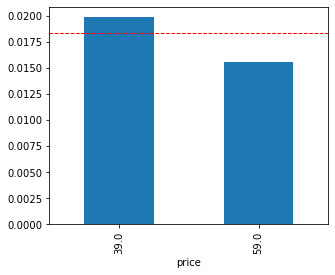

In [125]:
df.groupby(['price'])['converted'].mean().plot.bar(figsize=[5,4])
baseline = df['converted'].mean()
# plt.gca().set_ylim([20,100])
plt.gca().axhline(y=baseline, linewidth=1, color='r',linestyle='--')

Lower price has higher conversion rate.

### Effect of city 

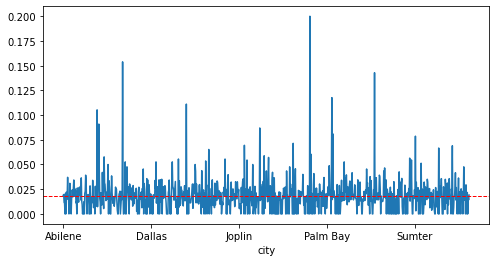

In [132]:
df.groupby(['city'])['converted'].mean().plot(figsize=[8,4])
baseline = df['converted'].mean()
# plt.gca().set_ylim([20,100])
plt.gca().axhline(y=baseline, linewidth=1, color='r',linestyle='--')

In [141]:
dfcity = df.groupby(['city'])['converted'].mean().reset_index()
dfcity.sort_values('converted', ascending=False).head(10)

,city,converted
561,North Atlanta,0.200000
135,Catonsville,0.153846
708,Saint Charles,0.142857
611,Parkway-South Sacramento,0.117647
280,Findlay,0.111111
77,Blue Springs,0.105263
81,Bonita Springs,0.090909
447,Lehigh Acres,0.086957
613,Parsippany-Troy Hills Township,0.081081
801,Sun City,0.078652


In these 10 cities, the conversion rate is much higher than the average values. 

### Effect of source

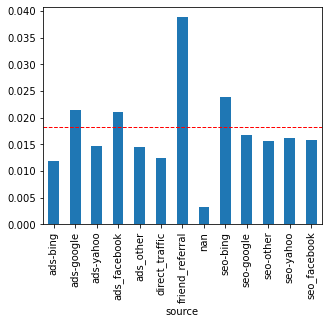

In [142]:
df.groupby(['source'])['converted'].mean().plot.bar(figsize=[5,4])
baseline = df['converted'].mean()
# plt.gca().set_ylim([20,100])
plt.gca().axhline(y=baseline, linewidth=1, color='r',linestyle='--')

Users from Friend ref, seo-bing, ads-goolge and adds-facebook have higher conversion rate.

### Effect of OS

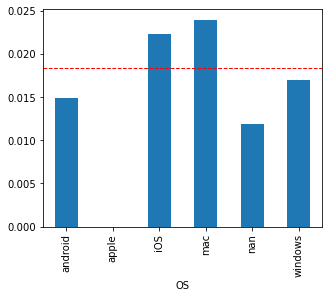

In [143]:
df.groupby(['OS'])['converted'].mean().plot.bar(figsize=[5,4])
baseline = df['converted'].mean()
# plt.gca().set_ylim([20,100])
plt.gca().axhline(y=baseline, linewidth=1, color='r',linestyle='--')

Users using iOS and mac have higher conversion rate.

### Effect of device

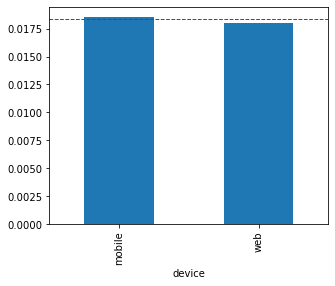

In [144]:
df.groupby(['device'])['converted'].mean().plot.bar(figsize=[5,4])
baseline = df['converted'].mean()
# plt.gca().set_ylim([20,100])
plt.gca().axhline(y=baseline, linewidth=1, color='r',linestyle='--')

## Decision tree

To derive actionable plan, I want to use the decision tree to find what is the top important features influcing the conversion. Since the model is for derive plan, I will just fit a shallow Decision Tree on all the data, without giving out model's performance on test set.

In [159]:
Xtrain = X[colnames]
ytrain = X.loc[:,'converted']

# One-Hot-Encoding on categorical features
Xtrain = pd.get_dummies(Xtrain)

In [160]:
from sklearn.tree import DecisionTreeClassifier,export_graphviz
dt = DecisionTreeClassifier(max_depth=4)
dt.fit(Xtrain,ytrain)

DecisionTreeClassifier(max_depth=4)

In [163]:
dotfile = open("I:\google drive\insight\data challenge\DC2\softwarePricing-master/dtree2.dot", 'w')
sklearn.tree.export_graphviz(dt,feature_names=Xtrain.columns,proportion=True,leaves_parallel=True)
dotfile.close()

## Actionable plan

#### friend_referral, Apple user (MAC or iOS), low price, and serveral specific cities are the four great positive factors which improve the conversion rate, specific plans as follows:

- Encourage friend refer: such as rewards user which can invite his/her friend to use our software.

- Increase the price will decrease the conversion rate, we must compensate on the other factors, such as lauch special marketing program targeted to Apple users (MAC or iOS users) or post more ads in specific cities. 

- windows and nan (guess should be Linux) users don't like our software as much as users on other OS. Development team should find out the reason. For example, is there any incompatibility issue on Linux?

# Q3: When should stop the test?

Definitely we can do a power analysis for it, but since we already get the data, so we can directly analysis when we already get statistically significant results.

In [180]:
df['date'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['date'].max() - df['date'].min()

Timedelta('90 days 23:55:33')

In [178]:
dfc = df.dropna()
import datetime as dt
dfc['days'] =((dfc['date'] - dfc['date'].min()).dt.total_seconds()/3600/24).astype(int)  +1 

<ipython-input-178-bd1ff24cf81e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfc['days'] =((dfc['date'] - dfc['date'].min()).dt.total_seconds()/3600/24).astype(int)  +1


In [179]:
dfc.sort_values(by = 'days').head()

,Unnamed: 0,user_id,timestamp,source,device,OS,test,price,converted,revenue,city,country,lat,long,date,days
132058,133340,317750,2015-03-02 08:30:37,ads_facebook,mobile,iOS,1,59.0,0,0.0,Bristol,USA,41.68,-72.94,2015-03-02 08:30:37,1
209115,211171,496683,2015-03-02 07:10:50,direct_traffic,mobile,iOS,0,39.0,0,0.0,Thousand Oaks,USA,34.19,-118.87,2015-03-02 07:10:50,1
209197,211254,989244,2015-03-02 11:44:24,ads_facebook,mobile,android,0,39.0,0,0.0,Omaha,USA,41.26,-96.01,2015-03-02 11:44:24,1
209262,211319,688031,2015-03-02 08:52:13,ads_facebook,web,windows,1,59.0,0,0.0,Nashville,USA,36.17,-86.78,2015-03-02 08:52:13,1
59924,60514,259720,2015-03-02 17:58:20,ads_facebook,web,mac,0,39.0,0,0.0,Richmond,USA,37.53,-77.47,2015-03-02 17:58:20,1


In [182]:
def mintesttime(dfc):
    for time in range(1, 91):
        data = dfc[dfc['days']<=time]
        new_Reve = data[data['test'] == 1]['revenue']
        old_Reve = data[data['test'] == 0]['revenue']
        t, p = ttest_ind(new_Reve, old_Reve, equal_var=False)
        n = data.shape[0]
        print("ttest_ind: t = %g  p = %g  n = %g" % (t, p, n))
        if p <0.05:
            return time
mintesttime(dfc)

ttest_ind: t = 0.796611  p = 0.425942  n = 1326
ttest_ind: t = -0.195412  p = 0.845093  n = 2588
ttest_ind: t = -1.13932  p = 0.254676  n = 3749
ttest_ind: t = 0.0379185  p = 0.969755  n = 6088
ttest_ind: t = 1.03603  p = 0.300223  n = 12054
ttest_ind: t = 1.75369  p = 0.0795145  n = 16728
ttest_ind: t = 1.67306  p = 0.0943401  n = 20512
ttest_ind: t = 1.60203  p = 0.109174  n = 21720
ttest_ind: t = 1.62471  p = 0.104247  n = 22986
ttest_ind: t = 1.81744  p = 0.0691713  n = 24169
ttest_ind: t = 2.03323  p = 0.0420465  n = 26571


11

At the 11th days (2015-03-12), the p-value is less than 0.05, which means there are statistically significant difference between control group and test group, so can stop the test. 